# ANN with/without GPU

we will consider 1 hidden layer and train the MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from torchvision.datasets import MNIST
from torchvision.utils import make_grid

from torch.utils import data 


In [8]:
train_data = MNIST( root = '~/Developer/PyTorch_YouTube/DATA/', download=True, 
                   transform=transforms.ToTensor(), train=True)

test_data = MNIST( root = '~/Developer/PyTorch_YouTube/DATA/', download=True, 
                   transform=transforms.ToTensor(), train=False)
print('Length of Training Data = ', len(train_data))
print('Length of Testing Data = ', len(test_data))

Length of Training Data =  60000
Length of Testing Data =  10000


# Initilize

In [10]:
batch_size = 100

val_size = 10000 # val_size = 10000, train_size = 50000
train_size = len(train_data) - val_size

### Converting 'train_data' into 'validation' and 'training' dataset

In [11]:
train_data, val_data = data.random_split(train_data, [train_size, val_size])

len(train_data), len(val_data)

(50000, 10000)

**num_workers** and **pin_memory**

In [12]:
train_batch = data.DataLoader(dataset= train_data, batch_size=batch_size, shuffle= True, num_workers=4, pin_memory=True) # Parellization = 4, pin_memory

test_batch = data.DataLoader(dataset= test_data, batch_size=batch_size*2, num_workers=4, pin_memory=True)

In [22]:
for img, _ in train_batch:
    print('img shape =', img.shape)
    print('Permute =', img.permute(2,3,1,0).shape)
    break

img shape = torch.Size([100, 1, 28, 28])
Permute = torch.Size([28, 28, 1, 100])


### permute(1,2,0):
The function changes the dimensions\
0th position value is placed in last position and so on

img.shape = torch.Size([100, 1, 28, 28])
torch.Size([3, 302, 302])


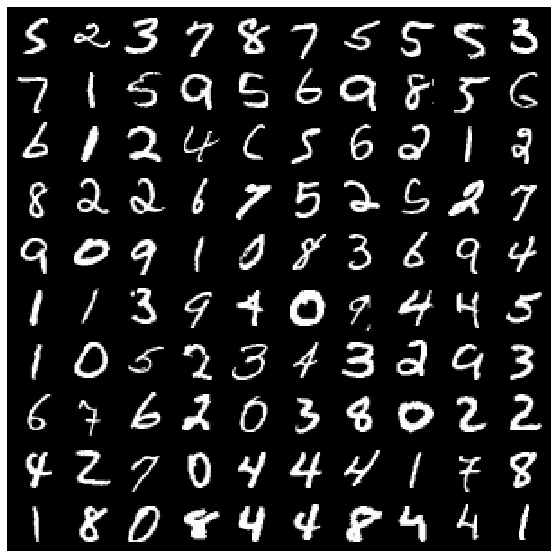

In [28]:
for img, _ in train_batch:
    print('img.shape =', img.shape)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    print(make_grid(img, nrow=10).shape)
    plt.imshow(make_grid(img, nrow=10).permute(1,2,0))
    # permute used to change the dim of the data
    break

In [23]:
def accuracy(outputs, labels):
    _, preds = torch.max(output, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item()/len(preds))

## Build Model with Training and Validation

In [30]:
# INITILIZE

img_size = 28*28

hidden_size = 32

n_class = 10


In [31]:
class NeuralNet(nn.Module):
    """Feed Forward Neural Network with 1 hidden Layer"""
    def __init__(self, img_size, hidden_size, n_class):
        super().__init__()
        self.FC1 = nn.Linear(img_size, hidden_size)
        self.FC2 = nn.Linear(hidden_size, n_class)
        
    def forward(self, img):
        #flatten the image
        flat_img = img.reshape(-1, img_size)
        
        layer1 = self.FC1(flat_img)
        # apply activation Layer
        activation = F.relu(layer1)
        
        out = self.FC2(activation)
        
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)   # it calls forward(img) function
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, label = batch
        out = self(images)
        loss = F.cross_entropy(out, label)
        acc = accuracy(out, label)
        return {'Validation_Loss =': loss.detach(), 'Validation_Acc =':acc}
    
    def validation_epoch_end(self, output):
        batch_loss = [x['Validation_Loss'] for x in output]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x['Validation_Acc'] for x in output]
        epoch_acc = torch.stack(batch_acc).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        

In [32]:
model = NeuralNet(img_size, hidden_size, n_class)


# Train the Model

Take 1st Batch (100 images) and pass through the model

In [35]:
for images, labels in train_batch:
    output = model(images)
    loss = F.cross_entropy(output, labels)
    print(loss.item())
    loss.backward()
    print(loss.item())
    break
    

2.313486337661743
2.313486337661743


In [36]:
torch.cuda.is_available()

False

In [39]:
for images, labels in train_batch:
    print(images.shape)
    data.to(device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])


AttributeError: module 'torch.utils.data' has no attribute 'to'